<span style="font-family: Arial; color: #1f608d; font-size: 36px;">Data Pre Processing </span>

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">Project Name : Customer Credit Analysis Project</span>

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">Created By : Raj Dalsaniya</span>


![credit analysis image](credit_worth.jpg)

<span style="font-family: Arial; color: #1f418f; font-size: 36px;">In this project, we aim to analyze the creditworthiness of our customers based on their financial data.</span>

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">Importing Libraries 📚</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#import Scipy libarary for statistical analysis
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import skew,kurtosis
from tabulate import tabulate
import statsmodels.api as sm
from scipy.stats import ttest_ind
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from scipy.special import boxcox1p
from sklearn.metrics import roc_auc_score,mean_squared_error,accuracy_score,f1_score
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder,  StandardScaler
from category_encoders import BinaryEncoder, CountEncoder, TargetEncoder, HashingEncoder

In [2]:
warnings.simplefilter(action='ignore')

<span style="font-family: Arial; color: #1f618d; font-size: 36px;">Importing Data 📊</span>

In [3]:
Data = pd.read_excel("Consumer_creditworthiness_train_data.xlsx")
Data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,294853,Male,No,0,Graduate,No,1316025,0.0,250000,360.0,1.0,Urban,Y
1,162883,Male,Yes,1,Graduate,No,1031175,339300.0,256000,360.0,1.0,Rural,N
2,620668,Male,Yes,0,Graduate,Yes,675000,0.0,132000,360.0,1.0,Urban,Y
3,295747,Male,Yes,0,Not Graduate,No,581175,530550.0,240000,360.0,1.0,Urban,Y
4,133390,Male,No,0,Graduate,No,1350000,0.0,282000,360.0,1.0,Urban,Y


<span style="font-family: Arial; color: #1f618d; font-size: 36px;">Checking Column Datatype 📊</span>

In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            521 non-null    int64  
 1   Gender             511 non-null    object 
 2   Married            518 non-null    object 
 3   Dependents         508 non-null    object 
 4   Education          521 non-null    object 
 5   Self_Employed      494 non-null    object 
 6   ApplicantIncome    521 non-null    int64  
 7   CoapplicantIncome  521 non-null    float64
 8   LoanAmount         521 non-null    int64  
 9   Loan_Amount_Term   507 non-null    float64
 10  Credit_History     478 non-null    float64
 11  Property_Area      521 non-null    object 
 12  Loan_Status        521 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 53.0+ KB


In [5]:
Data.isnull().sum()

Loan_ID               0
Gender               10
Married               3
Dependents           13
Education             0
Self_Employed        27
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">🧮 Missing Value Imputation:</span>

In [6]:
#get the index of the null columns for Loan_Amount_Term - train
index_NaN_Loan_Amount_Term = list(Data["Loan_Amount_Term"][Data["Loan_Amount_Term"].isnull()].index)

for i in index_NaN_Loan_Amount_Term:
    Loan_Amount_Term_med = Data["Loan_Amount_Term"].median()
    
    Loan_Amount_Term_pred = Data["Loan_Amount_Term"][((Data["Gender"] == Data.iloc[i]["Gender"]) & (Data["Married"] == Data.iloc[i]["Married"]) & (Data["Education"] == Data.iloc[i]["Education"]) &(Data["Self_Employed"] == Data.iloc[i]["Self_Employed"]) & (Data["Dependents"] == Data.iloc[i]["Dependents"]))].median()
    
    if not np.isnan(Loan_Amount_Term_med):
        Data["Loan_Amount_Term"].iloc[i] = Loan_Amount_Term_pred
    else:
        Data["Loan_Amount_Term"].iloc[i] = Loan_Amount_Term_med

In [7]:
# create an instance of SimpleImputer with strategy='most_frequent'
imputer = SimpleImputer(strategy='most_frequent')

# fit the imputer to the dataset
imputer.fit(Data[["Gender","Married","Dependents","Self_Employed","Loan_Amount_Term","Credit_History"]])

# transform the dataset by imputing missing values
Data[["Gender","Married","Dependents","Self_Employed","Loan_Amount_Term","Credit_History"]] = imputer.transform(Data[["Gender","Married","Dependents","Self_Employed","Loan_Amount_Term","Credit_History"]])

# converting array to dataframe again
Data = pd.DataFrame(Data, columns =Data.columns)

In [8]:
df_imputed = Data.copy()

<span style="font-family: Arial; color: #1f608d; font-size: 26px;">Evaluting Categorical encoding methods: Finding best method for dataset💻🔍</span>

In [9]:
# Replace '3+' with '3' in the Dependents column
df_imputed['Dependents'] = df_imputed['Dependents'].replace('3+', '3')

# Convert the Dependents column to float data type
df_imputed['Dependents'] = df_imputed['Dependents'].astype(float)

<span style="font-family: Arial; color: #1f608d; font-size: 26px;">Categorical Value Encoding 💻</span>

In [10]:
label_encoder = LabelEncoder()

In [11]:
# Encode labels in column 'Gender'.
df_imputed['Gender']= label_encoder.fit_transform(df_imputed['Gender'])

# Encode labels in column 'Gender'.
df_imputed['Education']= label_encoder.fit_transform(df_imputed['Education'])

# Encode labels in column 'Gender'.
df_imputed['Property_Area']= label_encoder.fit_transform(df_imputed['Property_Area'])

In [12]:
# Define a dictionary to map "Yes" and "No" to binary values
binary_map = {'Yes': 1, 'No': 0}

# Apply binary encoding to the "Married" and "Self_Employed" columns
df_imputed['Married'] = df_imputed['Married'].map(binary_map)
df_imputed['Self_Employed'] = df_imputed['Self_Employed'].map(binary_map)

In [13]:
# Convert "Y" to 1 and "N" to 0 in the "Loan_Status" column
df_imputed['Loan_Status'] = df_imputed['Loan_Status'].replace({'Y': 1, 'N': 0})

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🛠️ Feature Engineering</span>

In [14]:
df_feature = df_imputed.copy()

In [15]:
# creating new feature:  total income 
df_feature["Total_Income"] = df_feature["ApplicantIncome"] + df_feature["CoapplicantIncome"]

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #1:</h3>
    <p>🤔 Does the Total Income have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ TThere is no significant correlation between Total_Income and Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant positive correlation between Total_Income and Loan Approval Rate.<p>
</div>

In [16]:
# Calculate the Pearson correlation coefficient and p-value
corr, p_value = stats.pearsonr(df_feature['Total_Income'], df_feature['Loan_Status'])

# Print the results
print("Pearson correlation coefficient:", corr)
print("P-value:", p_value)

# Check if the p-value is less than 0.05 (the chosen significance level)
if p_value < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant positive correlation between Total_Income and Loan Approval Rate.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that there is a statistically significant relationship between Total_Income and Loan Approval Rate.")

Pearson correlation coefficient: -0.023780171884345634
P-value: 0.5881179473524301
We fail to reject the null hypothesis.
There is not enough evidence to suggest that there is a statistically significant relationship between Total_Income and Loan Approval Rate.


<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 2 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with EMI coefficient is 0.58, which is much higher than the typical significance level of 0.05. This means that we fails to reject the null hypothesis that there is no significant impact between Total_Income  and Loan Status. In other words, there is  enough evidence to suggest that there is a no statistically significant relationship between Total_Income  and Loan Status in this dataset.

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🛠️ Creating New Feature : EMI</span>

EMI stands for Equated Monthly Installment, which is a fixed payment amount made by a borrower to a lender at a specified date each calendar month. The EMI is typically used to repay a loan, such as a home loan, personal loan, or car loan, over a fixed period of time.

$$EMI = \frac{P \times r \times (1 + r)^n}{(1 + r)^n - 1}$$

In [17]:
# Calculate EMI for each loan applicant
df_feature['Interest_Rate'] = np.where(df_feature['Credit_History']==1, 10.0, 15.0) # assuming interest rate of 10% for those with credit history and 15% for those without
df_feature['EMI'] = (df_feature['LoanAmount'] * (df_feature['Interest_Rate'] / 1200) * (1 + (df_feature['Interest_Rate'] / 1200)) ** df_feature['Loan_Amount_Term']) / ((1 + (df_feature['Interest_Rate'] / 1200)) ** df_feature['Loan_Amount_Term'] - 1)

In [18]:
df_feature["Loan_Amount_Term"] = df_feature["Loan_Amount_Term"].astype("float64")
df_feature["EMI"] = df_feature["EMI"].astype("float64")
df_feature["Credit_History"] = df_feature["Credit_History"].astype("float64")

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #2:</h3>
    <p>🤔 Does the EMI have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of EMI on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant  impact of EMI on Loan Approval Rate.<p>
</div>

In [19]:
import pandas as pd
import statsmodels.api as sm

# Fit a logistic regression model with EMI as the predictor and Loan_Status_Binary as the outcome
X = df_feature['EMI']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of EMI on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that EMI has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.614575
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                 0.01094
Time:                        21:29:02   Log-Likelihood:                -320.19
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                  0.007793
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1411      0.168      6.807      0.000       0.813       1.470
EMI           -0.0001   4.92e

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 2 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with EMI coefficient is 0.010, which is much lower than the typical significance level of 0.05. This means that we reject the null hypothesis that there is no significant impact between Residual_monthly_income and Loan Status. In other words, there is  enough evidence to suggest that there is a statistically significant relationship between EMI and Loan Status in this dataset.

In [20]:
# Define a function to calculate additional monthly expenses based on property area
def additional_monthly_expenses(row):
    if row['Property_Area'] ==  2:
        return 15000
    elif row['Property_Area'] == 1:
        return 10000
    elif row['Property_Area'] == 0:
        return 5000
    else:
        return 0  # if there is missing or incorrect data

# Apply the function to create a new column called "Additional_Monthly_Income"
df_feature['Additional_Monthly_expenses'] = df_feature.apply(additional_monthly_expenses, axis=1)

In [21]:
df_feature['residual_Income'] = (df_feature["Total_Income"] / 12) - (df_feature['EMI']) + ((df_feature['Dependents']+1)*(df_feature['Additional_Monthly_expenses']))

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #3:</h3>
    <p>🤔 Does the residual_Income have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant correlation between residual_Income and Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant positive correlation between residual_Income and Loan Approval Rate.<p>
</div>

In [22]:
import pandas as pd
import statsmodels.api as sm

# Fit a logistic regression model with EMI as the predictor and Loan_Status_Binary as the outcome
X = df_feature['residual_Income']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of residual_Income on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that residual_Income has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.621196
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:               0.0002802
Time:                        21:29:03   Log-Likelihood:                -323.64
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                    0.6701
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8338      0.145      5.751      0.000       0.550       1.118
residual_Incom

In [23]:
df_feature['Income_Per_Person'] = df_feature['Total_Income'] / (df_feature['Dependents'] + 1)

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of Income_Per_Person on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant impact of Income_Per_Person on Loan Approval Rate.<p>
</div>

In [24]:
# create a contingency table
contingency_table = pd.crosstab(df_feature['Income_Per_Person'], df_feature['Loan_Status'])

# perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

In [25]:
# Check if the p-value is less than 0.05 (the chosen significance level)
if p_value < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Income_Per_Person on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Income_Per_Person has a significant impact on Loan Status.")

We fail to reject the null hypothesis.
There is not enough evidence to suggest that Income_Per_Person has a significant impact on Loan Status.


<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 5 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with EMI coefficient is 0.55, which is much higher than the typical significance level of 0.05. This means that we fails reject the null hypothesis that there is no significant impact between Income_Per_Person  and Loan Status. In other words, there is  enough evidence to suggest that there is a no statistically significant relationship between Income_Per_Person and Loan Status in this dataset.

In [26]:
# creating new feature
df_feature['Credit_History_and_Income_Per_Person'] = df_feature['Credit_History'] * df_feature['Income_Per_Person']

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of Credit_History_and_Income_Per_Person on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant impact of Credit_History_and_Income_Per_Person on Loan Approval Rate.<p>
</div>

In [27]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status_Binary as the outcome
X = df_feature['Credit_History_and_Income_Per_Person']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Credit_History_and_Income_Per_Person on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Credit_History_and_Income_Per_Person has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.604391
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                 0.02732
Time:                        21:29:03   Log-Likelihood:                -314.89
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                 2.597e-05
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.3318      0.1

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 6 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with EMI coefficient is 0.000, which is much lower than the typical significance level of 0.05. This means that we reject the null hypothesis that there is no significant impact between Credit_History_and_Income_Per_Person  and Loan Status. In other words, there is  enough evidence to suggest that there is a statistically significant relationship between Credit_History_and_Income_Per_Person and Loan Status in this dataset.

In [28]:
df_feature['Credit_History_Duration'] = np.where(df_feature['Credit_History'] == 1, df_feature['Loan_Amount_Term'] / 12, 0)

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #7:</h3>
    <p>🤔 Does the Credit_History_Duration have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of Credit_History_Duration on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant impact of Credit_History_Duration on Loan Approval Rate.<p>
</div>

In [29]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status_Binary as the outcome
X = df_feature['Credit_History_Duration']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Credit_History_Duration on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Credit_History_Duration has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.523801
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                  0.1570
Time:                        21:29:03   Log-Likelihood:                -272.90
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                 6.570e-24
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.2939      0.255     -5.077      0.000      -1.793   

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 7 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with EMI coefficient is 0.000, which is much lower than the typical significance level of 0.05. This means that we reject the null hypothesis that there is no significant impact between Credit_History_Duration   and Loan Status. In other words, there is  enough evidence to suggest that there is a statistically significant relationship between Credit_History_Duration  and Loan Status in this dataset.

In [30]:
# calculate the 75th percentile of the ApplicantIncome column
income_threshold = df_feature['ApplicantIncome'].quantile(0.75)

# create Has_Short_Term_Employment feature
df_feature['Has_Short_Term_Employment'] = ((df_feature['Self_Employed'] == 'Yes') | (df_feature['ApplicantIncome'] < income_threshold)).astype(int)

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #8:</h3>
    <p>🤔 Does the Has_Short_Term_Employment have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of Has_Short_Term_Employment on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant impact of Has_Short_Term_Employment on Loan Approval Rate.<p>
</div>

In [31]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['Has_Short_Term_Employment']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Has_Short_Term_Employment on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Has_Short_Term_Employment has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.621186
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:               0.0002959
Time:                        21:29:03   Log-Likelihood:                -323.64
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                    0.6616
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.7161      0.186      3.849      0.000       0.

In [32]:
# Multiply Credit_History and encoded Property_Area to create Credit_Property feature
df_feature['Credit_Property'] = df_feature['Credit_History'] * df_feature['Property_Area']

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #9:</h3>
    <p>🤔 Does the Credit_Property have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of Credit_Property on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant impact of Credit_Property on Loan Approval Rate.<p>
</div>

In [33]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['Credit_Property']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Credit_Property on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Credit_Property has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.579169
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                 0.06792
Time:                        21:29:03   Log-Likelihood:                -301.75
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                 3.330e-11
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1273      0.135      0.947      0.344      -0.136       0.391
Credit_Propert

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 9 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with Credit_Property coefficient is 0.000, which is much lower than the typical significance level of 0.05. This means that we reject the null hypothesis that there is no significant impact between Credit_Property   and Loan Status. In other words, there is  enough evidence to suggest that there is a statistically significant relationship between Credit_Property  and Loan Status in this dataset.

In [34]:
# Multiply Education and Self_Employed to create Edu_Self_Emp feature
df_feature['Edu_Self_Emp'] = df_feature['Education'] *df_feature['Self_Employed']

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #10:</h3>
    <p>🤔 Does the Edu_Self_Emp have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of Edu_Self_Emp on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant impact of Edu_Self_Emp on Loan Approval Rate.<p>
</div>

In [35]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['Edu_Self_Emp']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Edu_Self_Emp on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Edu_Self_Emp has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.620554
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                0.001313
Time:                        21:29:03   Log-Likelihood:                -323.31
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                    0.3565
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8017      0.096      8.346      0.000       0.613       0.990
Edu_Self_Emp    -0.5140

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 10 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with Edu_Self_Emp coefficient is 0.349, which is much lower than the typical significance level of 0.05. This means that we fails to reject the null hypothesis that there is no significant impact between Edu_Self_Emp and Loan Status. In other words, there is  enough evidence to suggest that there is a nostatistically significant relationship between Edu_Self_Emp  and Loan Status in this dataset.

In [36]:
df_feature['Debt_Income_Ratio'] = df_feature['LoanAmount'] / df_feature['Total_Income']

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #11:</h3>
    <p>🤔 Does the Debt_Income_Ratio have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of Debt_Income_Ratio on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant impact of Debt_Income_Ratio on Loan Approval Rate.<p>
</div>

In [37]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['Debt_Income_Ratio']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Debt_Income_Ratio on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Debt_Income_Ratio has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.620130
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                0.001995
Time:                        21:29:03   Log-Likelihood:                -323.09
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                    0.2557
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0549      0.256      4.119      0.000       0.553       1.557
Debt_Inc

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 11 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with Debt_Income_Ratio  coefficient is 0.256, which is much lower than the typical significance level of 0.05. This means that we fails to reject the null hypothesis that there is no significant impact between Debt_Income_Ratio and Loan Status. In other words, there is  enough evidence to suggest that there is a no statistically significant relationship between Debt_Income_Ratio and Loan Status in this dataset.

In [38]:
df_feature['Credit_History_Self_Emp'] = (df_feature['Credit_History'] * df_feature['Self_Employed'])+1

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Hypothesis analysis for Newly created feature</span>

<div class="alert alert-block alert-info">
    <h3>Statistical Question #12:</h3>
    <p>🤔 Does the Credit_History_Self_Emp have impact on Loan Status?</p>
</div>

<div class="alert alert-block alert-info"> 
    <p><b>Null Hypothesis:</b> 🤷‍♂️ There is no significant impact of Credit_History_Self_Emp on Loan Approval Rate.

<b>Alternative Hypothesis:</b> 🤔  There is a significant impact of Credit_History_Self_Emp on Loan Approval Rate.<p>
</div>

In [39]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['Credit_History_Self_Emp']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Credit_History_Self_Emp on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Credit_History_Self_Emp has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.617871
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                0.005631
Time:                        21:29:03   Log-Likelihood:                -321.91
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                   0.05620
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1077      0.380      0.283      0.777      -0.637   

<span style="font-family: Arial; color: #1f608d; font-size: 36px;">📊🔍 Statatical Question - 6 Analysis Conclusion:</span>

Based on the given hypothesis test with a significance level of 0.05, p-value associated with Credit_History_Self_Emp coefficient is 0.068, which is  lower than the typical significance level of 0.05. This means that we fails to reject the null hypothesis that there is no significant impact between Credit_History_Self_Emp and Loan Status. In other words, there is  enough evidence to suggest that there is a no statistically significant relationship between Credit_History_Self_Emp  and Loan Status in this dataset.

P value is much near to significance level... more investigation needed , we will check during modeling 

In [40]:
# Calculate Loan Amount per Month
df_feature['LoanAmount_per_Month'] = df_feature['LoanAmount'] / df_feature['Loan_Amount_Term']

In [41]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['LoanAmount_per_Month']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of LoanAmount_per_Month on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that LoanAmount_per_Month has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.621335
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:               5.640e-05
Time:                        21:29:03   Log-Likelihood:                -323.72
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                    0.8485
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7711      0.126      6.135      0.000       0.525       1.017

In [42]:
# Calculate Total Dependents : assuming suppose is dependent to applicant
df_feature['Total_Dependents'] = df_feature['Dependents'] + df_feature['Married']

In [43]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['Total_Dependents']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Total_Dependents on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Total_Dependents has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.620102
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                0.002041
Time:                        21:29:03   Log-Likelihood:                -323.07
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                    0.2504
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6684      0.139      4.816      0.000       0.396       0.940
Total_Depen

In [44]:
# third Feature : LoanAmount_per_Total_Income
df_feature["LoanAmount_per_Total_Income"] = df_feature["LoanAmount"] / df_feature["Total_Income"]

In [45]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['LoanAmount_per_Total_Income']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of LoanAmount_per_Total_Income on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that LoanAmount_per_Total_Income has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.620130
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                0.001995
Time:                        21:29:03   Log-Likelihood:                -323.09
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                    0.2557
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.0549      0.256      4.119      0.000   

In [46]:
# we will drop Loan_ID,Additional_Monthly_expenses,Total_Monthly_Expenses,     
df_feature = df_feature.drop(["Loan_ID","Additional_Monthly_expenses"], axis = 1)

In [47]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Gender                                521 non-null    int32  
 1   Married                               521 non-null    int64  
 2   Dependents                            521 non-null    float64
 3   Education                             521 non-null    int32  
 4   Self_Employed                         521 non-null    int64  
 5   ApplicantIncome                       521 non-null    int64  
 6   CoapplicantIncome                     521 non-null    float64
 7   LoanAmount                            521 non-null    int64  
 8   Loan_Amount_Term                      521 non-null    float64
 9   Credit_History                        521 non-null    float64
 10  Property_Area                         521 non-null    int32  
 11  Loan_Status        

In [48]:
df_feature["Total_Money_Needs_Paid"] = df_feature["EMI"] * df_feature["Loan_Amount_Term"]
df_feature["Total_Interest_Payable"] = df_feature["Total_Money_Needs_Paid"] - df_feature["LoanAmount"]

In [49]:
# Fit a logistic regression model with EMI as the predictor and Loan_Status as the outcome
X = df_feature['Total_Money_Needs_Paid']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Total_Money_Needs_Paid on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Total_Money_Needs_Paid has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.607778
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                 0.02187
Time:                        21:29:04   Log-Likelihood:                -316.65
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                 0.0001677
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.3444      0.183      7.333      0.000       0.985      

In [50]:
# Fit a logistic regression model with Total_Interest_Payable as the predictor and Loan_Status as the outcome
X = df_feature['Total_Interest_Payable']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Total_Interest_Payable on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Total_Interest_Payable has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.599692
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                 0.03489
Time:                        21:29:04   Log-Likelihood:                -312.44
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                 2.007e-06
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.4758      0.185      7.972      0.000       1.113      

<span style="font-family: Arial; color: #1f608d; font-size: 32px;">🕵️‍♀️Creating New Feature : Credit_Worthiness_Score</span>

In [51]:
# Define the weights for each feature
weights = {"Credit_History": 500, "Credit_History_Duration": 300, "Credit_Property": 200, "Total_Money_Needs_Paid": -100, 
           "Total_Interest_Payable": -100, "Interest_Rate": -500, "EMI": -300}

# Calculate the Creditworthiness Score
df_feature["Creditworthiness_Score"] = 0
for feature, weight in weights.items():
    df_feature["Creditworthiness_Score"] += df_feature[feature] * weight

# Scale the Creditworthiness Score to a range of 0 to 1000
min_score = df_feature["Creditworthiness_Score"].min()
max_score = df_feature["Creditworthiness_Score"].max()
df_feature["Creditworthiness_Score"] = (df_feature["Creditworthiness_Score"] - min_score) / (max_score - min_score) * 1000

In [52]:
# Fit a logistic regression model with Total_Interest_Payable as the predictor and Loan_Status as the outcome
X = df_feature['Creditworthiness_Score']
y = df_feature['Loan_Status']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

# Print the model summary
print(model.summary())

# Check if the p-value for the EMI coefficient is less than 0.05 (the chosen significance level)
if model.pvalues[1] < 0.05:
    print("We reject the null hypothesis and accept the alternative hypothesis.")
    print("There is evidence of a significant impact of Creditworthiness_Score on Loan Status.")
else:
    print("We fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Creditworthiness_Score has a significant impact on Loan Status.")

Optimization terminated successfully.
         Current function value: 0.604567
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  521
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Mar 2023   Pseudo R-squ.:                 0.02704
Time:                        21:29:04   Log-Likelihood:                -314.98
converged:                       True   LL-Null:                       -323.73
Covariance Type:            nonrobust   LLR p-value:                 2.859e-05
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.2118      0.762     -2.902      0.004      -3.705      

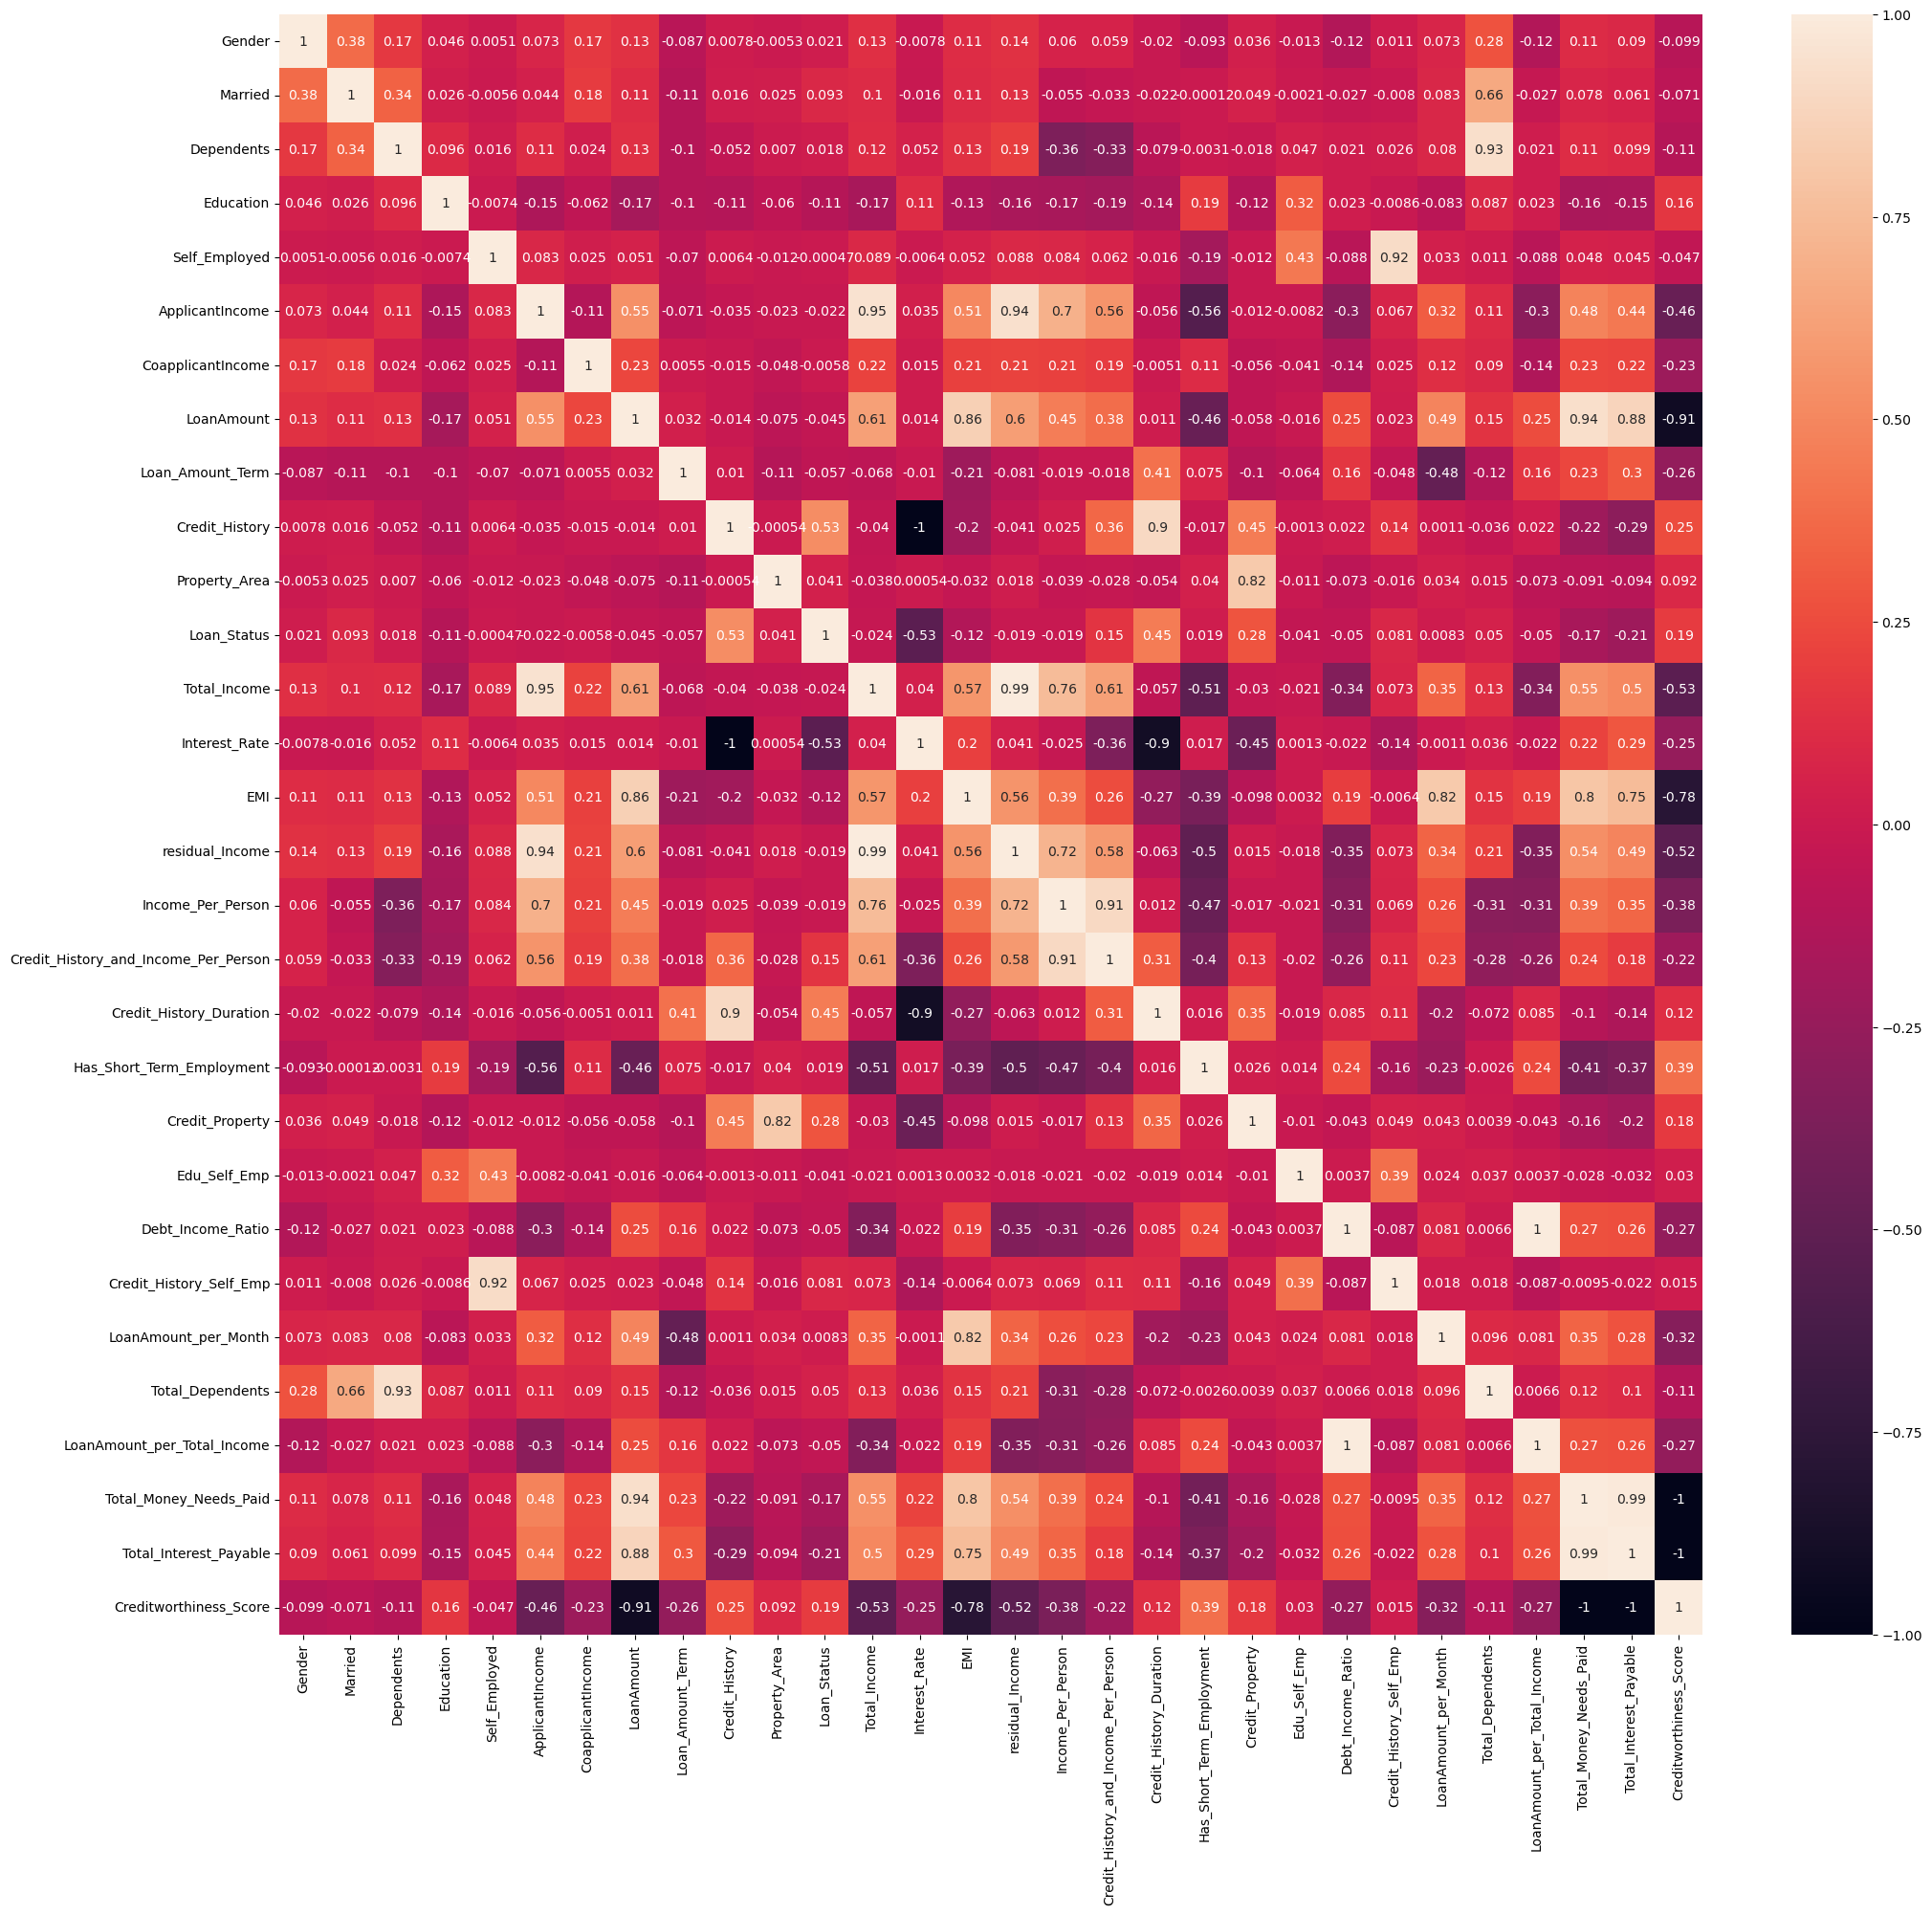

In [53]:
# Create a scatter plot of Creditworthiness_Score and LoanAmount_per_Total_Income
plt.figure(figsize = (24,22))
sns.heatmap(df_feature.corr(), annot = True)
# Show the chart
plt.show()

In [54]:
# EMI ,Credit_History_Duration,Credit_Property,Credit_History_and_Income_Per_Person,Total_Interest_Payable,Total_Money_Needs_Paid,Creditworthiness_Score

# Credit_History_Self_Emp  : P value is very close... might be useful feature           

In [55]:
# saving data in csv file 
df_feature.to_csv("processed_data.csv", index = False)

In [56]:
test_data = pd.read_excel("consumer creditworthiness test data.xlsx")
test_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,788264,Male,No,0,Graduate,No,562500,0,110000,360,1.0,Semiurban
1,431937,Male,Yes,3+,Graduate,Yes,1277325,320400,200000,360,1.0,Rural
2,425437,Male,Yes,2,Graduate,Yes,1788300,1612350,960000,360,1.0,Rural
3,938101,Male,No,0,Graduate,No,1053000,469575,0,360,1.0,Semiurban
4,180559,Male,Yes,2,Graduate,Yes,3937500,0,800000,360,1.0,Rural


In [57]:
# Replace '3+' with '3' in the Dependents column
test_data['Dependents'] = test_data['Dependents'].replace('3+', '3')

# Convert the Dependents column to float data type
test_data['Dependents'] = test_data['Dependents'].astype(float)

In [58]:
# Encode labels in column 'Gender'.
test_data['Gender']= label_encoder.fit_transform(test_data['Gender'])

# Encode labels in column 'Gender'.
test_data['Education']= label_encoder.fit_transform(test_data['Education'])

# Encode labels in column 'Gender'.
test_data['Property_Area']= label_encoder.fit_transform(test_data['Property_Area'])

In [60]:
# Define a dictionary to map "Yes" and "No" to binary values
binary_map = {'Yes': 1, 'No': 0}

# Apply binary encoding to the "Married" and "Self_Employed" columns
test_data['Married'] = test_data['Married'].map(binary_map)
test_data['Self_Employed'] = test_data['Self_Employed'].map(binary_map)

In [61]:
# creating new feature:  total income 
test_data["Total_Income"] = test_data["ApplicantIncome"] + test_data["CoapplicantIncome"]

In [62]:
# Calculate EMI for each loan applicant
test_data['Interest_Rate'] = np.where(test_data['Credit_History']==1, 10.0, 15.0) # assuming interest rate of 10% for those with credit history and 15% for those without
test_data['EMI'] = (test_data['LoanAmount'] * (test_data['Interest_Rate'] / 1200) * (1 + (test_data['Interest_Rate'] / 1200)) ** test_data['Loan_Amount_Term']) / ((1 + (test_data['Interest_Rate'] / 1200)) ** test_data['Loan_Amount_Term'] - 1)

In [63]:
test_data["Loan_Amount_Term"] = test_data["Loan_Amount_Term"].astype("float64")
test_data["EMI"] = df_feature["EMI"].astype("float64")
test_data["Credit_History"] = test_data["Credit_History"].astype("float64")

In [65]:
# Define a function to calculate additional monthly expenses based on property area
def additional_monthly_expenses(row):
    if row['Property_Area'] ==  2:
        return 15000
    elif row['Property_Area'] == 1:
        return 10000
    elif row['Property_Area'] == 0:
        return 5000
    else:
        return 0  # if there is missing or incorrect data

# Apply the function to create a new column called "Additional_Monthly_Income"
test_data['Additional_Monthly_expenses'] = test_data.apply(additional_monthly_expenses, axis=1)

In [66]:
test_data['residual_Income'] = (test_data["Total_Income"] / 12) - (test_data['EMI']) + ((test_data['Dependents']+1)*(test_data['Additional_Monthly_expenses']))

In [67]:
test_data['Income_Per_Person'] = test_data['Total_Income'] / (test_data['Dependents'] + 1)

In [68]:
# creating new feature
test_data['Credit_History_and_Income_Per_Person'] = test_data['Credit_History'] * test_data['Income_Per_Person']

In [69]:
test_data['Credit_History_Duration'] = np.where(test_data['Credit_History'] == 1, test_data['Loan_Amount_Term'] / 12, 0)

In [70]:
# Multiply Credit_History and encoded Property_Area to create Credit_Property feature
test_data['Credit_Property'] = test_data['Credit_History'] * test_data['Property_Area']

In [71]:
# Multiply Education and Self_Employed to create Edu_Self_Emp feature
test_data['Edu_Self_Emp'] = test_data['Education'] *test_data['Self_Employed']

In [72]:
test_data['Debt_Income_Ratio'] = test_data['LoanAmount'] / test_data['Total_Income']

In [73]:
test_data['Credit_History_Self_Emp'] = (test_data['Credit_History'] * test_data['Self_Employed'])+1

In [74]:
# Calculate Loan Amount per Month
test_data['LoanAmount_per_Month'] = test_data['LoanAmount'] / test_data['Loan_Amount_Term']

In [75]:
# Calculate Total Dependents : assuming suppose is dependent to applicant
test_data['Total_Dependents'] = test_data['Dependents'] + test_data['Married']

In [76]:
# third Feature : LoanAmount_per_Total_Income
test_data["LoanAmount_per_Total_Income"] = test_data["LoanAmount"] / test_data["Total_Income"]

In [77]:
test_data["Total_Money_Needs_Paid"] = test_data["EMI"] * test_data["Loan_Amount_Term"]
test_data["Total_Interest_Payable"] = test_data["Total_Money_Needs_Paid"] - test_data["LoanAmount"]

In [78]:
# Define the weights for each feature
weights = {"Credit_History": 500, "Credit_History_Duration": 300, "Credit_Property": 200, "Total_Money_Needs_Paid": -100, 
           "Total_Interest_Payable": -100, "Interest_Rate": -500, "EMI": -300}

# Calculate the Creditworthiness Score
test_data["Creditworthiness_Score"] = 0
for feature, weight in weights.items():
    test_data["Creditworthiness_Score"] += test_data[feature] * weight

# Scale the Creditworthiness Score to a range of 0 to 1000
min_score = test_data["Creditworthiness_Score"].min()
max_score = test_data["Creditworthiness_Score"].max()
test_data["Creditworthiness_Score"] = (test_data["Creditworthiness_Score"] - min_score) / (max_score - min_score) * 1000

In [79]:
# saving data in csv file 
test_data.to_csv("test_processed_data.csv", index = False)